In [1]:
import numpy as np
import scvi 
import torch
import pandas as pd
import torch.distributions as dist
import scanpy as sc
from scCFM.models.base.vae import VAE, AE
from scCFM.models.base.geometric_vae import GeometricNBAE,GeometricNBVAE
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from scvi.distributions import NegativeBinomial
from tqdm import tqdm

import scipy as sp
import  matplotlib.pyplot as plt

In [2]:
# Set seed for reproducibility
torch.manual_seed(42)

# Parameters
num_genes = 10  # Number of genes
num_cells = 1000  # Number of cells
num_cell_types = 3  # Number of cell types

dist_means = [dist.Normal(torch.zeros(num_genes)+1, torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes)+0.5, torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes), torch.ones(num_genes))]

In [3]:
dist_means

[Normal(loc: torch.Size([10]), scale: torch.Size([10])),
 Normal(loc: torch.Size([10]), scale: torch.Size([10])),
 Normal(loc: torch.Size([10]), scale: torch.Size([10]))]

In [4]:
# Generate inverse dispersion parameters (theta)
# Assume inverse dispersions are sampled from a gamma distribution
inverse_dispersion = torch.abs(torch.distributions.Gamma(2.0, 1.0).sample((num_genes,)))

# Generate size factors for each cell
size_factors = torch.exp(torch.distributions.LogNormal(0, 0.1).sample((num_cells,)))

# Assign cells to cell types (assuming balanced classes)
cell_type_indices = torch.randint(0, num_cell_types, (num_cells,))

In [5]:
# Initialize the counts matrix
counts = torch.zeros((num_cells, num_genes))
means = torch.zeros((num_cells, num_genes))

# Simulate counts for each cell
for i in range(num_cells):
    cell_type = cell_type_indices[i]
    mean = dist_means[cell_type].sample()
    # mu = size_factors[i] * torch.exp(mean)
    mu = torch.exp(mean)
    theta = inverse_dispersion

    means[i, :] = mu
    counts[i, :] = NegativeBinomial(mu=mu, theta=theta).sample()

# Show the first few simulated counts
print("Simulated Counts Matrix (first 5 cells, all 10 genes):")
print(counts[:5, :])  # Show first 5 cells and all 10 genes

Simulated Counts Matrix (first 5 cells, all 10 genes):
tensor([[ 0.,  0.,  0.,  0., 95.,  0.,  0.,  0.,  6.,  5.],
        [ 0.,  1.,  1.,  0.,  2.,  2.,  8.,  3.,  0.,  0.],
        [ 0.,  1.,  0., 13.,  3.,  3.,  4.,  0.,  0.,  0.],
        [ 0.,  7.,  0.,  1., 16., 25.,  2.,  1.,  6.,  1.],
        [ 8.,  1., 66.,  0.,  1.,  1.,  5.,  0.,  3.,  3.]])


# Scanpy visualization

In [6]:
adata = sc.AnnData(X=counts.numpy(), 
                  obs=pd.DataFrame({"cell_type": cell_type_indices.numpy()}))
adata.obs["cell_type"]=adata.obs["cell_type"].astype("category")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


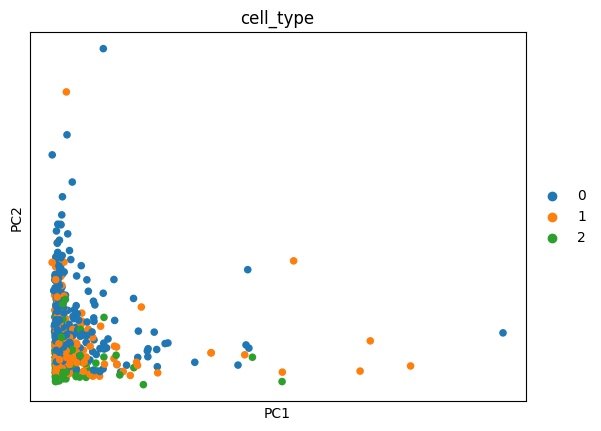

In [8]:
sc.pl.pca(adata, color="cell_type")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


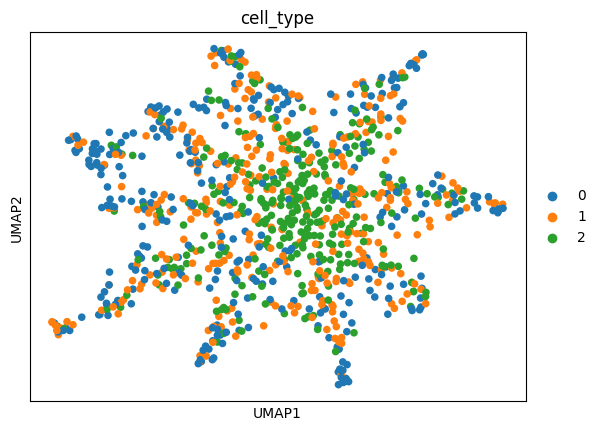

In [9]:
sc.pl.umap(adata, color="cell_type")

# Initialize FlatVI

In [10]:
class SingleCellDataset(Dataset):
    def __init__(self, counts):
        self.counts = counts

    def __len__(self):
        return len(self.counts)

    def __getitem__(self, idx):
        return {"X": self.counts[idx]}

# Create an instance of the custom dataset
dataset = SingleCellDataset(counts)

# Create a DataLoader to iterate over the dataset
batch_size = 32  # You can choose an appropriate batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
vae_kwargs = dict(in_dim=10,
                    hidden_dims=[10, 2],
                    batch_norm=False,
                    dropout=False,
                    dropout_p=False,
                    n_epochs_anneal_kl=500,
                    kl_warmup_fraction=2,
                    kl_weight=None, 
                    likelihood="nb", 
                    learning_rate=0.001, 
                    model_library_size=False)

In [12]:
model_vae = VAE(**vae_kwargs) 

In [13]:
model_flatvi = GeometricNBVAE(l2=True,
                        interpolate_z=False,
                        eta_interp=0,
                        start_jac_after=0,
                        use_c=False,
                        compute_metrics_every=1,
                        vae_kwargs=vae_kwargs, 
                        detach_theta=False,
                        fl_weight=10,
                        trainable_c=False,
                        anneal_fl_weight=False, 
                        max_fl_weight=False,
                        n_epochs_anneal_fl=None, 
                        fl_anneal_fraction=None)

In [14]:
logger_vae = WandbLogger(project="REBUTTAL_flatvi", offline= False,
                        id=None, # pass correct id to resume experiment!
                        log_model= True, # upload lightning ckpts
                        prefix= "", # a string to put at the beginning of metric keys
                        group= "",
                        tags= [],
                        job_type= "") 

trainer_vae = Trainer(max_epochs=100,
           logger=logger_vae)
             
# Fit the model 
trainer_vae.fit(model=model_vae, 
            train_dataloaders=dataloader, 
            val_dataloaders=dataloader,)

wandb: Currently logged in as: allepalma. Use `wandb login --relogin` to force relogin


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/scCFM/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/scCFM/lib ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A

Sanity Checking: 0it [00:00, ?it/s]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider incr

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [15]:
logger_flatvi = WandbLogger(project="REBUTTAL_flatvi", offline= False,
                        id=None, # pass correct id to resume experiment!
                        log_model= True, # upload lightning ckpts
                        prefix= "", # a string to put at the beginning of metric keys
                        group= "",
                        tags= [],
                        job_type= "") 

trainer_flatvi = Trainer(max_epochs=100,
           logger=logger_flatvi)
             
# Fit the model 
trainer_flatvi.fit(model=model_flatvi, 
            train_dataloaders=dataloader, 
            val_dataloaders=dataloader,)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory ./REBUTTAL_flatvi/a40pne2a/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-52c735f7-a582-5461-a060-43b869010675]

  | Name           | Type   | Params
------------------------------------------
0 | encoder_layers | MLP    | 110   
1 | d

Sanity Checking: 0it [00:00, ?it/s]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('reg_weight', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('fl_weight', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('reg_weight', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('fl_weight', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


# Compute geodesics with stochman

In [16]:
from typing import Optional

import torch
from torch.distributions import kl_divergence

from stochman.manifold import Manifold
from stochman.curves import BasicCurve, CubicSpline

from scCFM.models.manifold.geodesic import sc_geodesic_minimizing_energy
from scCFM.models.utils import get_distribution
from scCFM.models.manifold.utils import nb_kl

In [17]:
class LatentStatisticalManifold(Manifold):
    def __init__(self, model):
        # Initialize model 
        self.model = model 
         
    def curve_energy(self, curve: torch.Tensor):
        # Latent curve 
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        dt = (curve[:, :-1] - curve[:, 1:]).pow(2).sum(dim=-1).sqrt().squeeze(1)  # b
        kl = self._decode_and_kl(curve)  # KL distance 
        return torch.sum(kl.view(kl.shape[0], -1), dim=1) * (2 * (dt ** -1))

    def curve_length(self, curve: torch.Tensor):
        # Latent curve 
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        kl = self._decode_and_kl(curve) # Metric 
        return torch.sqrt(2 * torch.sum(kl.view(kl.shape[0], -1), dim=1))

    def connecting_geodesic(self, 
                            p0, 
                            p1, 
                            init_curve: Optional[BasicCurve] = None, 
                            max_iter=500, 
                            eval_grid=100, 
                            lr=1e-2, 
                            minimize_energy=True, 
                            return_losses=True):
         # Latent curve
        if init_curve is None:
            curve = CubicSpline(p0, p1)
        else:
            curve = init_curve
            curve.begin = p0
            curve.end = p1
        
        # Train the geodesic spline 
        losses = sc_geodesic_minimizing_energy(curve, 
                                                self, 
                                                max_iter=max_iter, 
                                                eval_grid=eval_grid,
                                                lr=lr, 
                                                minimize_energy=minimize_energy, 
                                                return_losses=return_losses)
        return curve, losses

    def metric(self, z, decoder_outputs):    
        # Compute the value of the Fisher matrix
        if self.model.likelihood == "nb":
            nb_fisher = self.model.theta.unsqueeze(0) / \
                (decoder_outputs * (self.model.theta.unsqueeze(0) + decoder_outputs))  # B x D
        else:
            raise NotImplementedError
        
        # Use the canonical basis vectors to select separate columns of the decoder (speed reasons)
        basis =  torch.eye(z.shape[1])
        basis = basis.unsqueeze(0).expand(z.shape[0], z.shape[1], z.shape[1])  # B x d x d
        
        # Compute the statistical manifold metric tensor 
        jac = []
        for i in range(z.shape[1]):
            _, jac_partial = torch.func.jvp(self.model.decode,
                                            (z,), 
                                            (basis[:, :, i],))  # B x D
            jac.append(jac_partial)

        jac = torch.stack(jac, dim=-1)  # B x D x d
        return torch.einsum("bij,bik->bjk", jac, jac * nb_fisher.unsqueeze(-1))
    
    def _decode_and_kl(self, curve):
        decoder_outputs1 = self.model.decode(curve[:, :-1, :])
        decoder_outputs2 = self.model.decode(curve[:, 1:, :])

        dist1 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs1), 
                                 self.model.theta, 
                                 likelihood = self.model.likelihood)
        dist2 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs2), 
                                 self.model.theta, 
                                 likelihood = self.model.likelihood)
        kl = nb_kl(dist1, dist2)  
        
        return kl

In [18]:
latent_manifold_vae = LatentStatisticalManifold(model_vae)
latent_manifold_flatvi = LatentStatisticalManifold(model_flatvi)

In [19]:
# dists_geodesic_latent = []
# dists_latent_latent = []
# for _ in tqdm(range(1000)):
#     i = np.random.choice(range(1000))
#     j = np.random.choice(range(1000))
#     c = latent_manifold.connecting_geodesic(latents[i], latents[j], minimize_energy=False)[0]
#     dists_geodesic_latent.append(compute_geodesic_dist(latent_manifold, c).item())
#     dists_latent_latent.append(torch.sum((latents[i] - latents[j] )**2).item())

In [20]:
# def compute_geodesic_dist(manifold, c):
#     alpha = torch.linspace(0, 1, 100)
#     traj = c(alpha)
#     return manifold.curve_length(traj)   

In [21]:
# plt.scatter(dists_geodesic_latent,dists_latent_latent)

In [22]:
# np.nanmean((np.array(dists_geodesic_latent)-np.array(dists_latent_latent))**2)

In [23]:
# plt.scatter(latents[i][0], latents[i][1])
# plt.scatter(latents[j][0], latents[j][1])
# curve = c(torch.linspace(0,1,100))
# for p in curve.detach().numpy():
#     plt.scatter(p[0], p[1])

# Additional

In [24]:
latents_vae = []

with torch.no_grad():
    for obs in counts:
        X = obs.unsqueeze(0)
        latent_vae = model_vae.encode(X)["z"]
        latents_vae.append(latent_vae)

latents_vae = torch.cat(latents_vae, dim=0)

In [25]:
latents_flatvi = []

with torch.no_grad():
    for obs in counts:
        X = obs.unsqueeze(0)
        latent_flatvi = model_flatvi.encode(X)["z"]
        latents_flatvi.append(latent_flatvi)

latents_flatvi = torch.cat(latents_flatvi, dim=0)

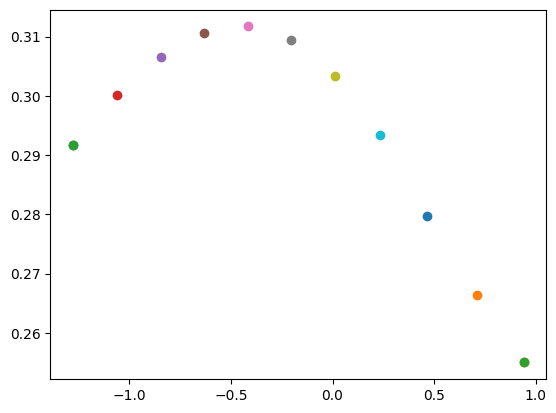

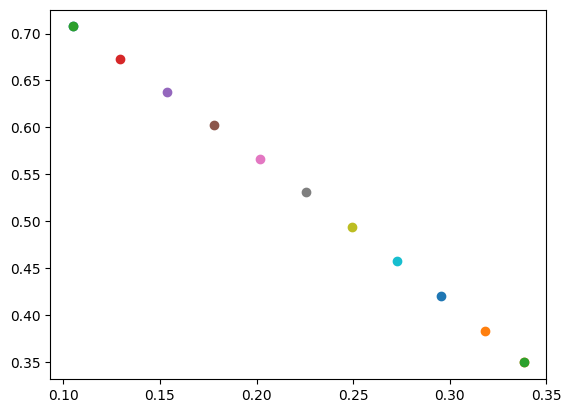

In [26]:
i = 23
j = 8  

c_vae = latent_manifold_vae.connecting_geodesic(latents_vae[i], latents_vae[j], minimize_energy=False)[0]
plt.scatter(latents_vae[i][0], latents_vae[i][1])
plt.scatter(latents_vae[j][0], latents_vae[j][1])
curve_vae = c_vae(torch.linspace(0,1,100))
for p in curve_vae.detach().numpy()[[0,10,20,30,40,50,60,70,80,90,99],:]:
    plt.scatter(p[0], p[1])
plt.show()

c_flatvi = latent_manifold_flatvi.connecting_geodesic(latents_flatvi[i], latents_flatvi[j], minimize_energy=False)[0]
plt.scatter(latents_flatvi[i][0], latents_flatvi[i][1])
plt.scatter(latents_flatvi[j][0], latents_flatvi[j][1])
curve_flatvi = c_flatvi(torch.linspace(0,1,100))
for p in curve_flatvi.detach().numpy()[[0,10,20,30,40,50,60,70,80,90,99],:]:
    plt.scatter(p[0], p[1])
plt.show()

In [27]:
for i in curve_vae[[0,10,20,30,40,50,60,70,80,90,99],:]:
    print(np.round(i[0].item(),2), np.round(i[1].item(),2))

-1.28 0.29
-1.06 0.3
-0.85 0.31
-0.63 0.31
-0.42 0.31
-0.2 0.31
0.01 0.3
0.23 0.29
0.47 0.28
0.71 0.27
0.94 0.25


In [28]:
for i in curve_flatvi[[0,10,20,30,40,50,60,70,80,90,99],:]:
    print(np.round(i[0].item(),2), np.round(i[1].item(),2))

0.1 0.71
0.13 0.67
0.15 0.64
0.18 0.6
0.2 0.57
0.23 0.53
0.25 0.49
0.27 0.46
0.3 0.42
0.32 0.38
0.34 0.35
